In [21]:
from pathlib import Path
import os
import pandas as pd

# -------- Locate the three core CSVs (accident, vehicle, person) --------
def find_fars_csvs(root="./FARS2023NationalCSV/FARS2023NationalCSV/FARS2023NationalCSV/"):
    paths = {}
    for dirpath, _, filenames in os.walk(root):
        for f in filenames:
            if f.lower().endswith(".csv"):
                p = Path(dirpath) / f
                if f.lower() == "accident.csv": paths["accident"] = p
                if f.lower() == "vehicle.csv":  paths["vehicle"]  = p
                if f.lower() == "person.csv":   paths["person"]   = p
    if len(paths) != 3:
        raise FileNotFoundError(f"Could not locate all 3 CSVs, found: {paths}")
    return paths

paths = find_fars_csvs("./FARS2023NationalCSV/FARS2023NationalCSV/FARS2023NationalCSV/")   # change to your local path if needed
acc = pd.read_csv(paths["accident"], low_memory=False)
veh = pd.read_csv(paths["vehicle"],  low_memory=False)
per = pd.read_csv(paths["person"],   low_memory=False)

print("Shapes:", {"accident": acc.shape, "vehicle": veh.shape, "person": per.shape})

# -------- Basic preprocessing --------
def drop_all_nulls(df: pd.DataFrame) -> pd.DataFrame:
    return df.dropna(axis=1, how="all")

def fill_object_unknown(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    obj_cols = out.select_dtypes(include=["object"]).columns
    out[obj_cols] = out[obj_cols].fillna("Unknown")
    return out

acc_clean = drop_all_nulls(acc)
veh_clean = drop_all_nulls(veh)
per_clean = drop_all_nulls(per)


print("Shapes:", {"accident": acc_clean.shape, "vehicle": veh_clean.shape, "person": per_clean.shape})

# # Optional: only if you WANT to fill strings with "Unknown"
# # acc_clean = fill_object_unknown(acc_clean)
# # veh_clean = fill_object_unknown(veh_clean)
# # per_clean = fill_object_unknown(per_clean)

# # -------- Null% report (top 15 per table) --------
# def top_nulls(df: pd.DataFrame, name: str, n=15) -> pd.DataFrame:
#     pct = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
#     out = pct.rename("pct_null").to_frame()
#     out.insert(0, "column", out.index)
#     out.insert(0, "table", name)
#     return out.reset_index(drop=True).head(n)

# null_report = pd.concat([
#     top_nulls(acc_clean, "accident"),
#     top_nulls(veh_clean, "vehicle"),
#     top_nulls(per_clean, "person"),
# ], ignore_index=True)

# print("\nTop nulls per table:\n", null_report)

# # -------- Simple EDA summaries --------
# # Crashes by state (Top 15)
# by_state = None
# for col in ["STATE", "STATENAME", "STATE_NAME"]:
#     if col in acc_clean.columns:
#         by_state = acc_clean[col].value_counts().rename("num_crashes").reset_index().head(15)
#         by_state.columns = [col, "num_crashes"]
#         break

# # Crashes by month (sorted)
# by_month = None
# if "MONTH" in acc_clean.columns:
#     by_month = acc_clean["MONTH"].value_counts().sort_index().rename("num_crashes").reset_index()
#     by_month.columns = ["MONTH", "num_crashes"]

# # Vehicles by body type (Top 15)
# by_body = None
# if "BODY_TYP" in veh_clean.columns:
#     by_body = veh_clean["BODY_TYP"].value_counts().head(15).rename("num_vehicles").reset_index()
#     by_body.columns = ["BODY_TYP", "num_vehicles"]

# # Person roles and injury severity
# per_type_ct = per_clean["PER_TYP"].value_counts().rename("count").reset_index() if "PER_TYP" in per_clean.columns else None
# inj_sev_ct  = per_clean["INJ_SEV"].value_counts().rename("count").reset_index() if "INJ_SEV" in per_clean.columns else None

# print("\nCrashes by State (Top 15):\n", by_state if by_state is not None else "STATE column missing")
# print("\nCrashes by Month:\n", by_month if by_month is not None else "MONTH column missing")
# print("\nVehicles by Body Type (Top 15):\n", by_body if by_body is not None else "BODY_TYP column missing")
# print("\nPerson Types:\n", per_type_ct if per_type_ct is not None else "PER_TYP column missing")
# print("\nInjury Severity Counts:\n", inj_sev_ct if inj_sev_ct is not None else "INJ_SEV column missing")


Shapes: {'accident': (37654, 80), 'vehicle': (58319, 203), 'person': (92400, 126)}
Shapes: {'accident': (37654, 80), 'vehicle': (58319, 203), 'person': (92400, 126)}


In [22]:
##Data Analysis

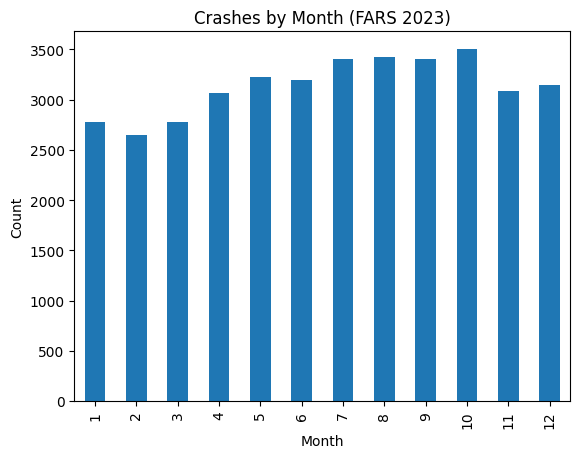

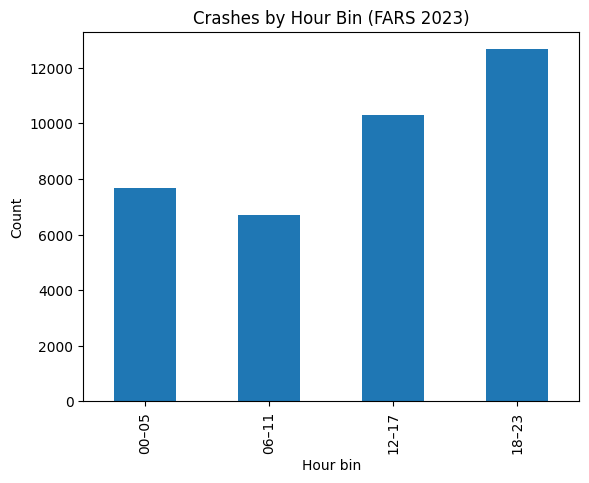

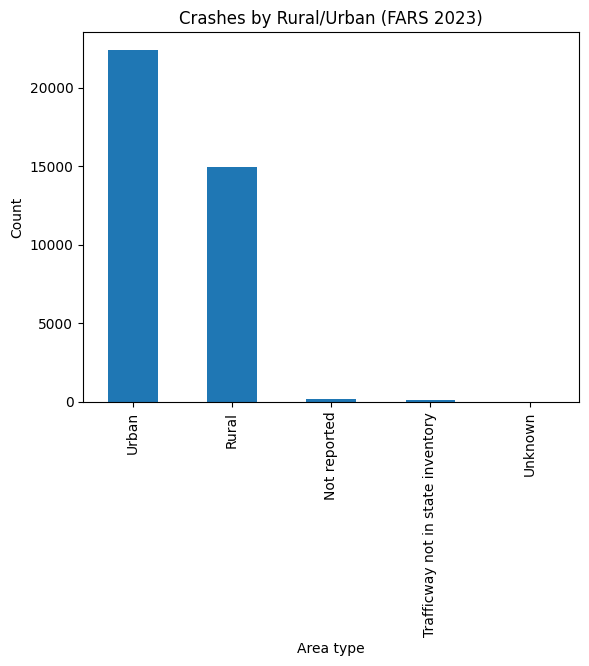

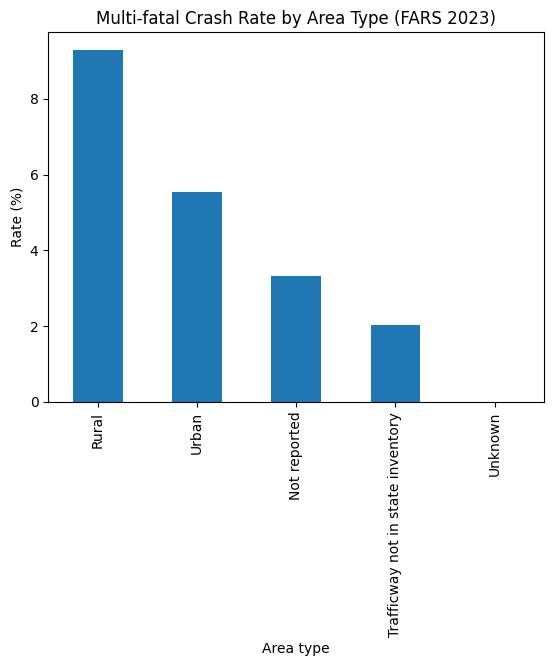

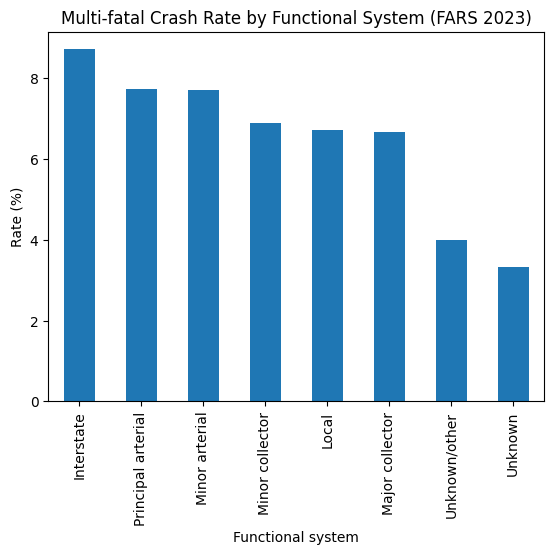

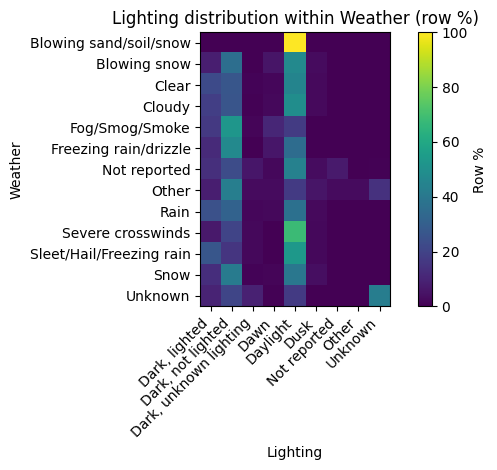

In [24]:
# Inline EDA plots (no files saved)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ACC_PATH = "./FARS2023NationalCSV/FARS2023NationalCSV/FARS2023NationalCSV/accident.csv"

# ---- mappings ----
RUR_URB_MAP = {1:"Rural",2:"Urban",6:"Trafficway not in state inventory",8:"Not reported",9:"Unknown"}
LGT_COND_MAP = {1:"Daylight",2:"Dark, not lighted",3:"Dark, lighted",4:"Dawn",5:"Dusk",6:"Dark, unknown lighting",7:"Other",8:"Not reported",9:"Unknown"}
WEATHER_MAP = {1:"Clear",2:"Rain",3:"Sleet/Hail/Freezing rain",4:"Snow",5:"Fog/Smog/Smoke",6:"Severe crosswinds",7:"Blowing sand/soil/snow",8:"Other",10:"Cloudy",11:"Blowing snow",12:"Freezing rain/drizzle",98:"Not reported",99:"Unknown"}
FUNC_SYS_MAP = {1:"Interstate",2:"Principal arterial",3:"Minor arterial",4:"Major collector",5:"Minor collector",6:"Local",7:"Unknown/other",8:"Not reported",9:"Unknown"}

def to_num(x): return pd.to_numeric(x, errors="coerce")
def map_code(s, mp): return to_num(s).map(mp).fillna("Unknown")
def hour_bin(h):
    h = to_num(h)
    return pd.cut(h, [-1,5,11,17,23], labels=["00–05","06–11","12–17","18–23"]).astype(str)

# ---- load + derive ----
acc = pd.read_csv(ACC_PATH, low_memory=False)
if "FATALS" in acc: acc["multi_fatal"] = (to_num(acc["FATALS"]) >= 2).astype(int)
if "HOUR"   in acc: acc["HOUR_BIN"] = hour_bin(acc["HOUR"])
if "RUR_URB" in acc: acc["RUR_URB_BUCKET"] = map_code(acc["RUR_URB"], RUR_URB_MAP)
if "LGT_COND" in acc: acc["LGT_BUCKET"] = map_code(acc["LGT_COND"], LGT_COND_MAP)
if "WEATHER" in acc: acc["WEATHER_BUCKET"] = map_code(acc["WEATHER"], WEATHER_MAP)
if "FUNC_SYS" in acc: acc["FUNC_SYS_BUCKET"] = map_code(acc["FUNC_SYS"], FUNC_SYS_MAP)

# ---- 1) Crashes by Month ----
if "MONTH" in acc:
    by_m = acc["MONTH"].value_counts().sort_index()
    plt.figure()
    by_m.plot(kind="bar")
    plt.title("Crashes by Month (FARS 2023)")
    plt.xlabel("Month"); plt.ylabel("Count")
    plt.show()

# ---- 2) Crashes by Hour Bin ----
if "HOUR_BIN" in acc:
    order = ["00–05","06–11","12–17","18–23"]
    by_hb = acc["HOUR_BIN"].value_counts().reindex(order).fillna(0)
    plt.figure()
    by_hb.plot(kind="bar")
    plt.title("Crashes by Hour Bin (FARS 2023)")
    plt.xlabel("Hour bin"); plt.ylabel("Count")
    plt.show()

# ---- 3) Rural/Urban counts ----
if "RUR_URB_BUCKET" in acc:
    vc_ru = acc["RUR_URB_BUCKET"].value_counts()
    plt.figure()
    vc_ru.plot(kind="bar")
    plt.title("Crashes by Rural/Urban (FARS 2023)")
    plt.xlabel("Area type"); plt.ylabel("Count")
    plt.show()

# ---- 4) Multi-fatal rate by Rural/Urban ----
if {"RUR_URB_BUCKET","multi_fatal"}.issubset(acc.columns):
    rate_ru = acc.groupby("RUR_URB_BUCKET")["multi_fatal"].mean().sort_values(ascending=False) * 100
    plt.figure()
    rate_ru.plot(kind="bar")
    plt.title("Multi-fatal Crash Rate by Area Type (FARS 2023)")
    plt.xlabel("Area type"); plt.ylabel("Rate (%)")
    plt.show()

# ---- 5) Multi-fatal rate by Functional System ----
if {"FUNC_SYS_BUCKET","multi_fatal"}.issubset(acc.columns):
    rate_fs = acc.groupby("FUNC_SYS_BUCKET")["multi_fatal"].mean().sort_values(ascending=False) * 100
    plt.figure()
    rate_fs.plot(kind="bar")
    plt.title("Multi-fatal Crash Rate by Functional System (FARS 2023)")
    plt.xlabel("Functional system"); plt.ylabel("Rate (%)")
    plt.show()

# ---- 6) Weather × Lighting heatmap (row %) ----
if {"WEATHER_BUCKET","LGT_BUCKET"}.issubset(acc.columns):
    ct = pd.crosstab(acc["WEATHER_BUCKET"], acc["LGT_BUCKET"], dropna=False)
    rowpct = (ct.div(ct.sum(axis=1), axis=0) * 100)
    plt.figure()
    plt.imshow(rowpct.values)
    plt.title("Lighting distribution within Weather (row %)")
    plt.xlabel("Lighting"); plt.ylabel("Weather")
    plt.xticks(range(rowpct.shape[1]), rowpct.columns, rotation=45, ha="right")
    plt.yticks(range(rowpct.shape[0]), rowpct.index)
    plt.colorbar(label="Row %")
    plt.tight_layout()
    plt.show()


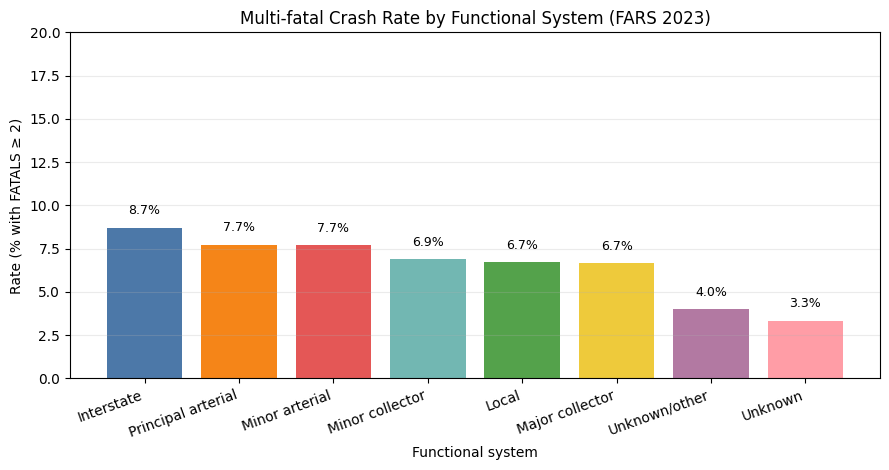

In [25]:
# ---- Multi-fatal rate by Functional System (prettier) ----
import matplotlib.pyplot as plt
import numpy as np

if {"FUNC_SYS_BUCKET","multi_fatal"}.issubset(acc.columns):
    rate_fs = (
        acc.groupby("FUNC_SYS_BUCKET")["multi_fatal"]
           .mean()
           .sort_values(ascending=False) * 100
    )

    colors = ["#4C78A8","#F58518","#E45756","#72B7B2",
              "#54A24B","#EECA3B","#B279A2","#FF9DA6",
              "#9D755D","#BAB0AC"][:len(rate_fs)]

    fig, ax = plt.subplots(figsize=(9, 4.8))
    bars = ax.bar(rate_fs.index, rate_fs.values, color=colors, edgecolor="none")

    for b, v in zip(bars, rate_fs.values):
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height() + 0.6,
            f"{v:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

    ax.set_title("Multi-fatal Crash Rate by Functional System (FARS 2023)")
    ax.set_ylabel("Rate (% with FATALS ≥ 2)")
    ax.set_xlabel("Functional system")
    ax.set_ylim(0, max(20, np.nanmax(rate_fs.values) + 5))
    ax.grid(axis="y", alpha=0.25)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()

    # save here
    plt.savefig("multi_fatal_by_funcsys.png", dpi=200, bbox_inches="tight")

    # and also show in notebook
    plt.show()


/tmp/ipykernel_2439/1714237217.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrRd")


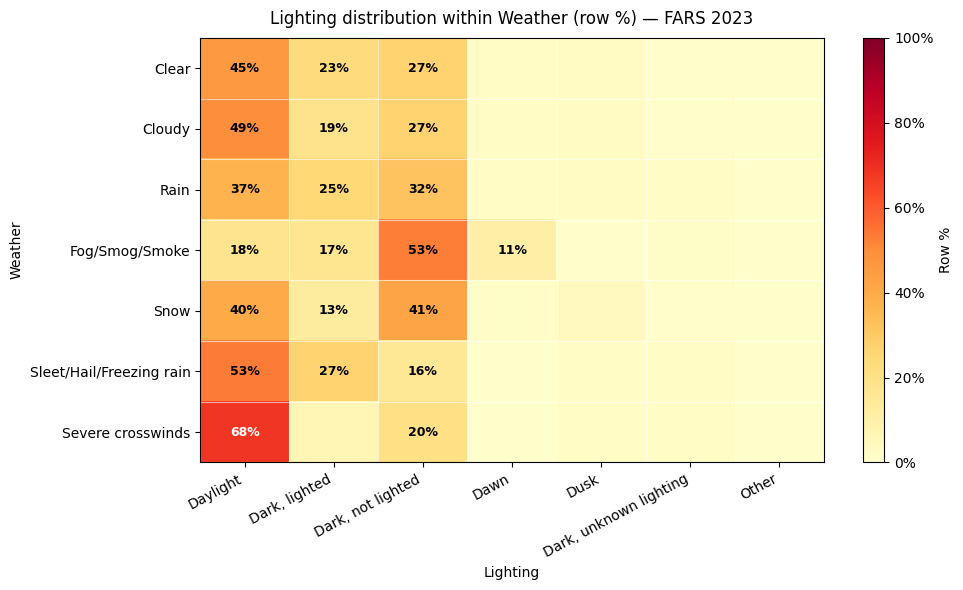

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
from matplotlib import cm

# --- keep your df / rowpct prep exactly as you had it above ---

# colormap: light = low, intense = high
cmap = cm.get_cmap("YlOrRd")
norm = Normalize(vmin=0, vmax=100)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(rowpct.values, cmap=cmap, norm=norm, aspect="auto")

# Force axis labels from your explicit orders
ax.set_title("Lighting distribution within Weather (row %) — FARS 2023", pad=10)
ax.set_xlabel("Lighting"); ax.set_ylabel("Weather")

# X axis (Lighting): use lgt_order explicitly
ax.set_xticks(np.arange(len(lgt_order)))
ax.set_xticklabels(lgt_order, rotation=28, ha="right")

# Y axis (Weather): use top_weather explicitly
ax.set_yticks(np.arange(len(top_weather)))
ax.set_yticklabels(top_weather)

# Percent colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _pos: f"{int(v)}%"))
cbar.set_label("Row %")

# Optional gridlines
ax.set_xticks(np.arange(-.5, len(lgt_order), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(top_weather), 1), minor=True)
ax.grid(which="minor", color="white", linewidth=0.8, alpha=0.6)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate only cells >=10% to reduce clutter
for i in range(rowpct.shape[0]):
    for j in range(rowpct.shape[1]):
        val = rowpct.iat[i, j]
        if val >= 10:
            # pick black/white for contrast
            r, g, b, _ = cmap(norm(val))
            luminance = 0.299*r + 0.587*g + 0.114*b
            txt_color = "black" if luminance > 0.6 else "white"
            ax.text(j, i, f"{val:.0f}%", ha="center", va="center",
                    fontsize=9, weight="bold", color=txt_color)

fig.tight_layout()
fig.savefig("lighting_distribution_within_weather.png", dpi=300, bbox_inches="tight")
fig.savefig("lighting_distribution_within_weather.svg", bbox_inches="tight")
plt.show()


In [ ]:
##HarmFul Event

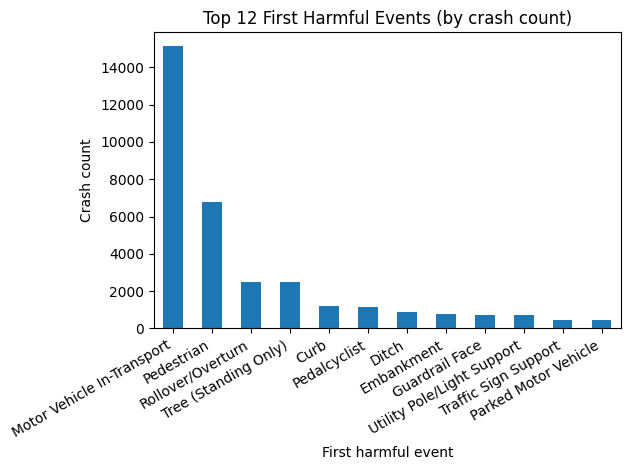

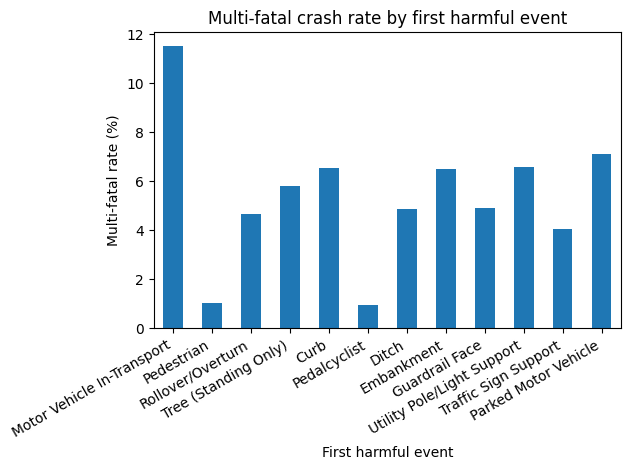

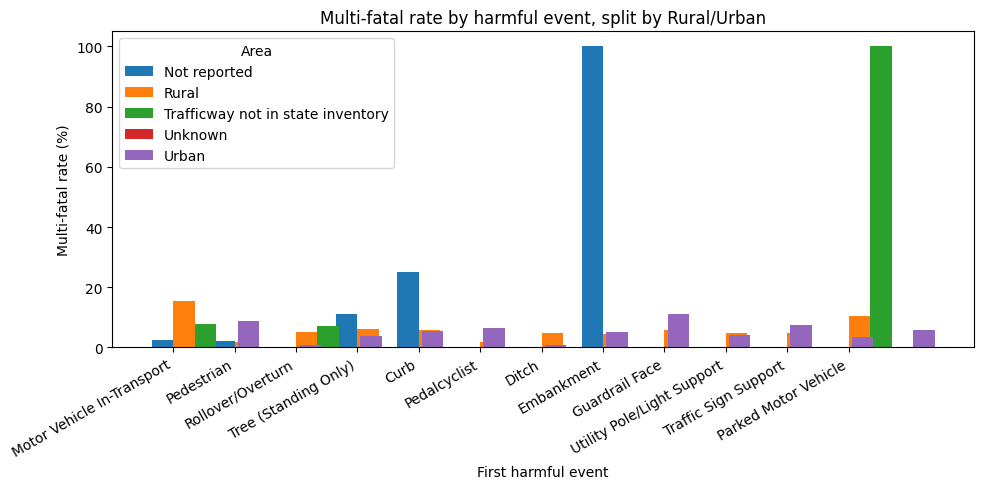

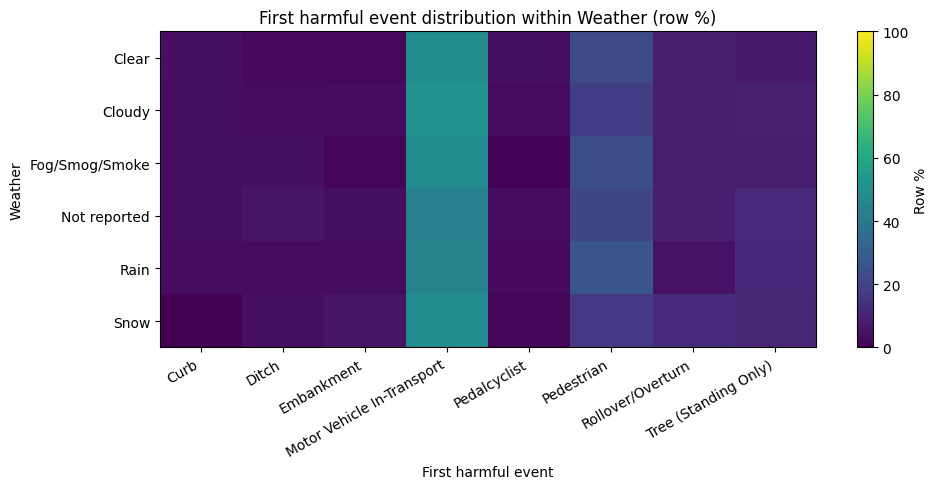

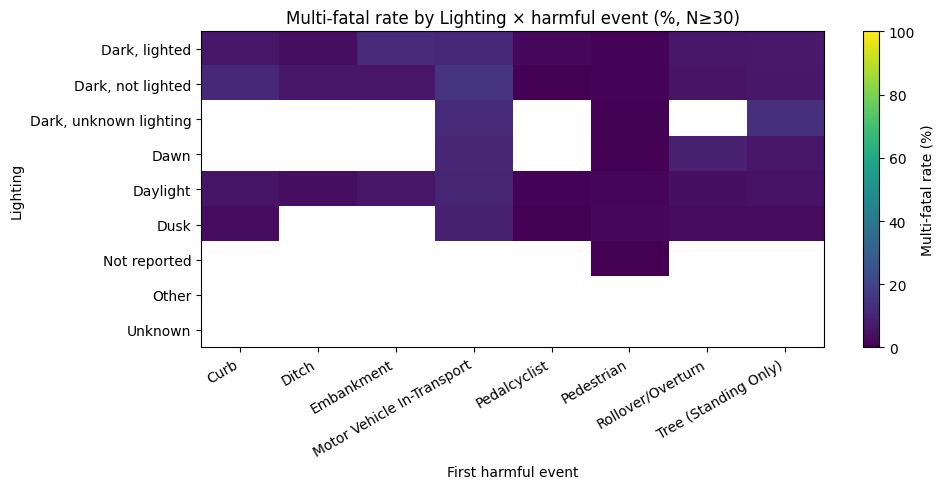

,HARM_BUCKET,WEATHER_BUCKET,LGT_BUCKET,rate,n
503,Motor Vehicle In-Transport,Cloudy,Dusk,16.071429,56
490,Motor Vehicle In-Transport,Clear,"Dark, not lighted",15.799171,2171
499,Motor Vehicle In-Transport,Cloudy,"Dark, not lighted",14.736842,380
498,Motor Vehicle In-Transport,Cloudy,"Dark, lighted",14.649682,314
515,Motor Vehicle In-Transport,Not reported,"Dark, not lighted",13.750000,80
529,Motor Vehicle In-Transport,Rain,Daylight,13.043478,506
152,Curb,Clear,"Dark, not lighted",13.008130,123
815,Railway Vehicle,Clear,Daylight,12.500000,64
506,Motor Vehicle In-Transport,Fog/Smog/Smoke,"Dark, not lighted",12.328767,73
489,Motor Vehicle In-Transport,Clear,"Dark, lighted",11.512524,2076


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = acc.copy()

# ---- pick a readable harmful-event name column if present ----
harm_name_col = None
for c in ["HARM_EVNAME","HARM_EV_NAME","FIRST_HARMFUL_EVENT_NAME","HARMFUL_EVENT_NAME"]:
    if c in df.columns:
        harm_name_col = c
        break

# fallback: coarse mapping from numeric HARM_EV to readable buckets
if harm_name_col is None and "HARM_EV" in df.columns:
    HARM_MAP_COARSE = {
        # non-collision
        1: "Non-collision (overturn/rollover)",
        2: "Non-collision (fire/explosion)",
        9: "Non-collision (other)",
        # pedestrians & cyclists
        12: "Pedestrian",
        14: "Pedalcyclist",
        # vehicle/parked
        7: "Parked motor vehicle",
        8: "Railway vehicle/train",
        # animals
        10: "Animal",
        # fixed objects (examples)
        20: "Tree",
        21: "Utility pole/light support",
        23: "Guardrail face",
        24: "Concrete barrier",
        26: "Bridge/overpass",
        31: "Embankment",
        # moving vehicle (generic)
        39: "Motor vehicle in transport",
        # catch-all
        99: "Unknown/other",
    }
    # map numeric to coarse text; unknowns bucketed
    s = pd.to_numeric(df["HARM_EV"], errors="coerce").map(HARM_MAP_COARSE).fillna("Other/unspecified")
    df["HARM_BUCKET"] = s
else:
    # use provided name directly
    df["HARM_BUCKET"] = df[harm_name_col].astype(str).str.strip().replace({"": "Unknown", "nan": "Unknown"})

# tidy label (optional)
df["HARM_BUCKET"] = df["HARM_BUCKET"].str.replace(r"\s+", " ", regex=True)

# ---- 1) Top harmful events by crash count ----
topN = 12
harm_counts = df["HARM_BUCKET"].value_counts().head(topN)

plt.figure()
harm_counts.plot(kind="bar")
plt.title(f"Top {topN} First Harmful Events (by crash count)")
plt.xlabel("First harmful event")
plt.ylabel("Crash count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# ---- 2) Multi-fatal rate (%) by harmful event (same topN ordering) ----
order = harm_counts.index.tolist()
rate_by_harm = (
    df.assign(is_top=df["HARM_BUCKET"].isin(order))
      .loc[lambda d: d["is_top"]]
      .groupby("HARM_BUCKET")["multi_fatal"]
      .mean().mul(100)
      .reindex(order)
)

plt.figure()
rate_by_harm.plot(kind="bar")
plt.title("Multi-fatal crash rate by first harmful event")
plt.xlabel("First harmful event")
plt.ylabel("Multi-fatal rate (%)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# ---- 3) Rural vs Urban multi-fatal rate by harmful event (grouped bars) ----
need_cols = {"HARM_BUCKET","RUR_URB_BUCKET","multi_fatal"}
if need_cols.issubset(df.columns):
    sub = df[df["HARM_BUCKET"].isin(order)].copy()
    g = (
        sub.groupby(["HARM_BUCKET","RUR_URB_BUCKET"])["multi_fatal"]
           .mean().mul(100).unstack("RUR_URB_BUCKET")
           .reindex(order)
    )
    plt.figure(figsize=(10,5))
    for i, col in enumerate(g.columns):
        # side-by-side bars
        plt.bar(np.arange(len(g)) + i*0.35, g[col].values, width=0.35, label=str(col))
    plt.title("Multi-fatal rate by harmful event, split by Rural/Urban")
    plt.xlabel("First harmful event"); plt.ylabel("Multi-fatal rate (%)")
    plt.xticks(np.arange(len(g)) + 0.35/2, g.index, rotation=30, ha="right")
    plt.legend(title="Area")
    plt.tight_layout()
    plt.show()

# ---- 4) Weather × harmful event (row-% within weather) heatmap for top weather + top harmful events ----
need_cols = {"WEATHER_BUCKET","HARM_BUCKET"}
if need_cols.issubset(df.columns):
    # limit to top weather rows and top harm cols to avoid clutter
    topW = df["WEATHER_BUCKET"].value_counts().head(6).index
    topH = df["HARM_BUCKET"].value_counts().head(8).index
    sub = df[df["WEATHER_BUCKET"].isin(topW) & df["HARM_BUCKET"].isin(topH)]
    ct = pd.crosstab(sub["WEATHER_BUCKET"], sub["HARM_BUCKET"], dropna=False)
    rowpct = (ct.div(ct.sum(axis=1), axis=0) * 100)
    plt.figure(figsize=(10,5))
    im = plt.imshow(rowpct.values, aspect="auto")
    plt.title("First harmful event distribution within Weather (row %)")
    plt.xlabel("First harmful event"); plt.ylabel("Weather")
    plt.xticks(range(rowpct.shape[1]), rowpct.columns, rotation=30, ha="right")
    plt.yticks(range(rowpct.shape[0]), rowpct.index)
    plt.colorbar(im, label="Row %"); plt.clim(0, 100)
    plt.tight_layout()
    plt.show()

# ---- 5) Multi-fatal rate heatmap for (Lighting × harmful event) with N threshold ----
need_cols = {"LGT_BUCKET","HARM_BUCKET","multi_fatal"}
if need_cols.issubset(df.columns):
    topH = df["HARM_BUCKET"].value_counts().head(8).index
    sub = df[df["HARM_BUCKET"].isin(topH)].copy()
    grp = (
        sub.groupby(["LGT_BUCKET","HARM_BUCKET"])["multi_fatal"]
           .agg(rate=lambda s: s.mean()*100, n="size")
           .reset_index()
    )
    rate = grp.pivot(index="LGT_BUCKET", columns="HARM_BUCKET", values="rate")
    n    = grp.pivot(index="LGT_BUCKET", columns="HARM_BUCKET", values="n")
    MIN_N = 30
    rate_masked = rate.where(n >= MIN_N)

    plt.figure(figsize=(10,5))
    im = plt.imshow(rate_masked.values, aspect="auto")
    plt.title("Multi-fatal rate by Lighting × harmful event (%, N≥30)")
    plt.xlabel("First harmful event"); plt.ylabel("Lighting")
    plt.xticks(range(rate_masked.shape[1]), rate_masked.columns, rotation=30, ha="right")
    plt.yticks(range(rate_masked.shape[0]), rate_masked.index)
    plt.colorbar(im, label="Multi-fatal rate (%)"); plt.clim(0, 100)
    plt.tight_layout()
    plt.show()

# ---- 6) (Optional) Top cells by multi-fatal rate with minimum sample size ----
need_cols = {"HARM_BUCKET","WEATHER_BUCKET","LGT_BUCKET","multi_fatal"}
if need_cols.issubset(df.columns):
    grp3 = (
        df.groupby(["HARM_BUCKET","WEATHER_BUCKET","LGT_BUCKET"])["multi_fatal"]
          .agg(rate=lambda s: s.mean()*100, n="size")
          .reset_index()
    )
    MIN_N = 50
    top_cells = grp3[grp3["n"] >= MIN_N].sort_values("rate", ascending=False).head(10)
    display(top_cells)  # in Jupyter this prints a nice table


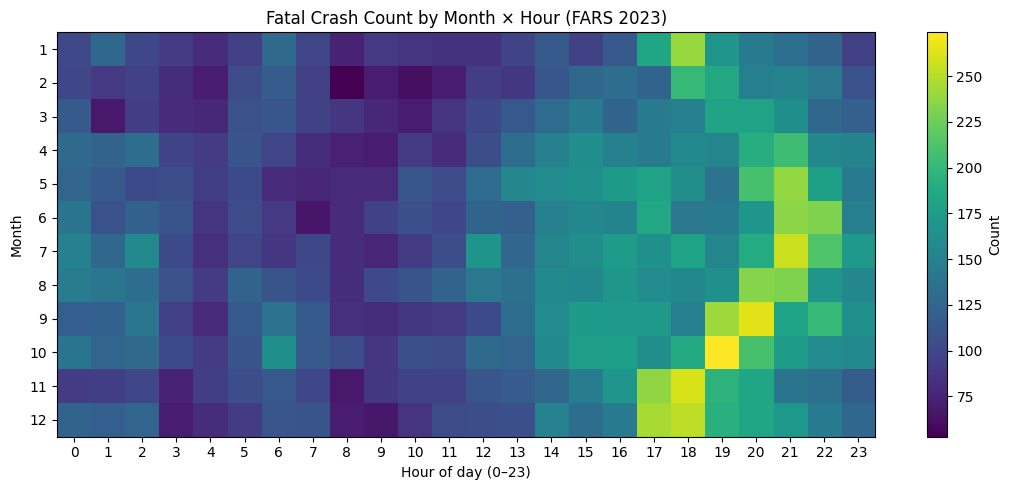

<Figure size 640x480 with 0 Axes>

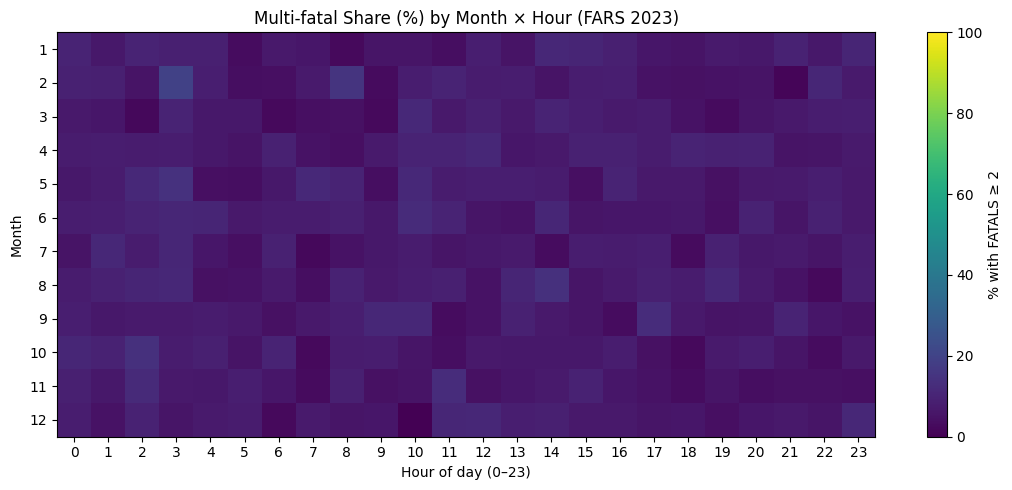

/tmp/ipykernel_2439/2710791249.py:88: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_day.pivot_table(index="DAY_NAME", columns="HOUR", values="ST_CASE", aggfunc="size", fill_value=0)


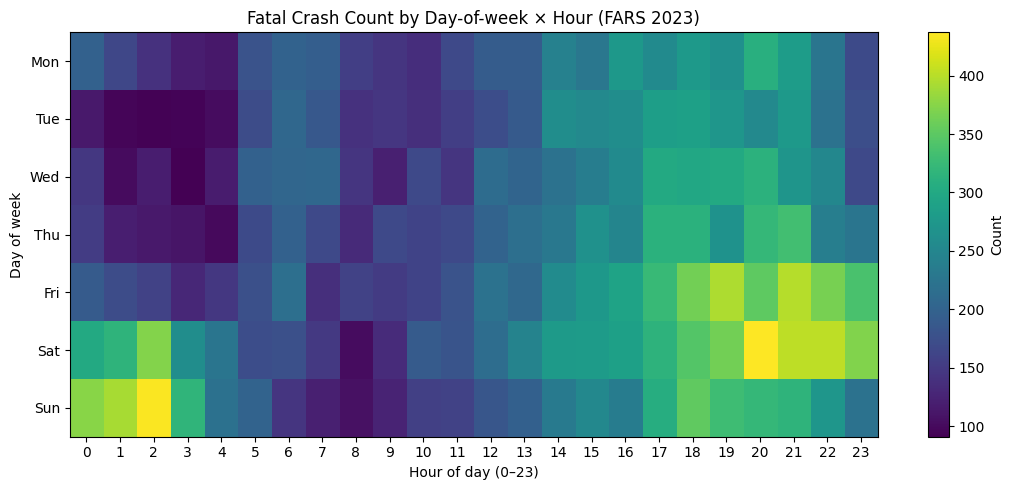

/tmp/ipykernel_2439/2710791249.py:99: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grp_dh = df_day.pivot_table(index="DAY_NAME", columns="HOUR", values="multi_fatal", aggfunc=["mean","size"])
/tmp/ipykernel_2439/2710791249.py:99: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grp_dh = df_day.pivot_table(index="DAY_NAME", columns="HOUR", values="multi_fatal", aggfunc=["mean","size"])


<Figure size 640x480 with 0 Axes>

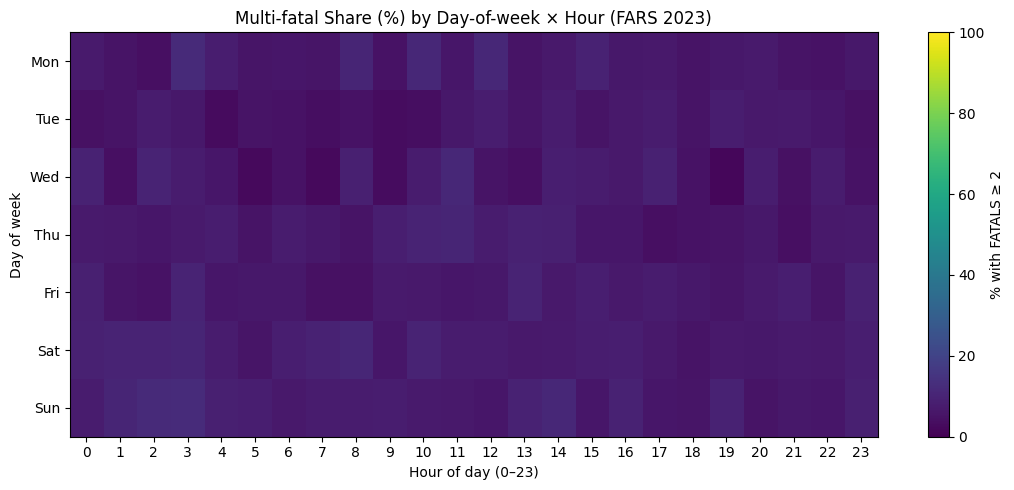

In [18]:
# === FARS 2023 heatmaps: Month×Hour & Day×Hour ===
# Plots:
# 1) Fatal crash COUNT by Month × Hour
# 2) Multi-fatal SHARE (%) by Month × Hour
# 3) Fatal crash COUNT by Day-of-week × Hour
# 4) Multi-fatal SHARE (%) by Day-of-week × Hour

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------- Path to accident.csv --------------------
ACC_PATH = Path("./FARS2023NationalCSV/FARS2023NationalCSV/FARS2023NationalCSV/accident.csv")
# If you put the file elsewhere, just change ACC_PATH to your location.

# -------------------- Load & basic derivations --------------------
acc = pd.read_csv(ACC_PATH, low_memory=False)

to_num = lambda s: pd.to_numeric(s, errors="coerce")
df = acc.copy()

# Multi-fatal indicator (within fatal crashes dataset)
df["multi_fatal"] = (to_num(df.get("FATALS")) >= 2).astype(int)

# Month / Hour
df["MONTH"] = to_num(df.get("MONTH"))
df["HOUR"]  = to_num(df.get("HOUR"))

# Day-of-week (FARS: 1=Sun ... 7=Sat); display Mon→Sun for readability
dow_map = {1:"Sun", 2:"Mon", 3:"Tue", 4:"Wed", 5:"Thu", 6:"Fri", 7:"Sat"}
df["DAY_NAME"] = to_num(df.get("DAY_WEEK")).map(dow_map)

# Keep sensible ranges
df = df[(df["MONTH"].between(1,12, inclusive="both")) & (df["HOUR"].between(0,23, inclusive="both"))]

month_labels = list(range(1,13))
hour_labels  = list(range(24))
day_order    = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

# -------------------- Helper: draw a heatmap from a pivot --------------------
def heatmap_from_pivot(piv, title, xlabel, ylabel, vmin=None, vmax=None, cbar_label=None):
    plt.figure(figsize=(11,5))
    im = plt.imshow(piv.values, aspect="auto", vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(range(piv.shape[1]), piv.columns, rotation=0)
    plt.yticks(range(piv.shape[0]), piv.index)
    cbar = plt.colorbar(im)
    if cbar_label:
        cbar.ax.set_ylabel(cbar_label)
    plt.tight_layout()
    plt.show()

# -------------------- 1) Fatal crash COUNT by Month × Hour --------------------
count_mh = (
    df.pivot_table(index="MONTH", columns="HOUR", values="ST_CASE", aggfunc="size", fill_value=0)
      .reindex(index=month_labels, columns=hour_labels, fill_value=0)
)
heatmap_from_pivot(
    count_mh, "Fatal Crash Count by Month × Hour (FARS 2023)",
    xlabel="Hour of day (0–23)", ylabel="Month", cbar_label="Count"
)

plt.savefig("FATAL_CRASH_COUNT_MONTH_HOUR.png", dpi=300, bbox_inches="tight")

# -------------------- 2) Multi-fatal SHARE (%) by Month × Hour ----------------
grp_mh = df.pivot_table(index="MONTH", columns="HOUR", values="multi_fatal", aggfunc=["mean","size"])
rate_mh = (grp_mh["mean"] * 100).reindex(index=month_labels, columns=hour_labels)
n_mh    = grp_mh["size"].reindex(index=month_labels, columns=hour_labels)

# Mask low-N cells to avoid noisy rates (tweak MIN_N if you like)
MIN_N = 10
rate_mh_masked = rate_mh.where(n_mh >= MIN_N)

heatmap_from_pivot(
    rate_mh_masked, "Multi-fatal Share (%) by Month × Hour (FARS 2023)",
    xlabel="Hour of day (0–23)", ylabel="Month",
    vmin=0, vmax=100, cbar_label="% with FATALS ≥ 2"
)

# -------------------- 3) Fatal crash COUNT by Day-of-week × Hour -------------
df_day = df.dropna(subset=["DAY_NAME"]).copy()
# reorder days
df_day["DAY_NAME"] = pd.Categorical(df_day["DAY_NAME"], categories=day_order, ordered=True)

count_dh = (
    df_day.pivot_table(index="DAY_NAME", columns="HOUR", values="ST_CASE", aggfunc="size", fill_value=0)
         .reindex(index=day_order, columns=hour_labels, fill_value=0)
)
heatmap_from_pivot(
    count_dh, "Fatal Crash Count by Day-of-week × Hour (FARS 2023)",
    xlabel="Hour of day (0–23)", ylabel="Day of week", cbar_label="Count"
)

plt.savefig("FATAL_CRASH_COUNT_DAY_HOUR.png", dpi=300, bbox_inches="tight")

# -------------------- 4) Multi-fatal SHARE (%) by Day-of-week × Hour ---------
grp_dh = df_day.pivot_table(index="DAY_NAME", columns="HOUR", values="multi_fatal", aggfunc=["mean","size"])
rate_dh = (grp_dh["mean"] * 100).reindex(index=day_order, columns=hour_labels)
n_dh    = grp_dh["size"].reindex(index=day_order, columns=hour_labels)
rate_dh_masked = rate_dh.where(n_dh >= MIN_N)

heatmap_from_pivot(
    rate_dh_masked, "Multi-fatal Share (%) by Day-of-week × Hour (FARS 2023)",
    xlabel="Hour of day (0–23)", ylabel="Day of week",
    vmin=0, vmax=100, cbar_label="% with FATALS ≥ 2"
)
